### Feature Pages
In this notebook, we want to look at the loan period in terms of the number of pages in the books. 

In [1]:
%config InlineBackend.figure_format = 'retina'

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from IPython.display import display, Markdown
from itertools import combinations
from utils import setup_pandas, setup_plotting


# --- global notebook setup (pandas + tueplots/matplotlib style) ---
setup_pandas()
setup_plotting()


# --- project paths ---
PROCESSED_DATA_PATH = Path('../dat/processed')
CLEANED_FILE = PROCESSED_DATA_PATH / "borrowings_2019_2025_cleaned.csv"


## Merge borrowings and media inventory data to add pages information.
Create "data/processed/borrowings_with_pages.csv" by matching on normalized ISBN and falling back to Barcode/EAN when ISBN is not available.

In [2]:
#--- merge borrowings with page numbers from media inventory ---
def normalize_isbn(val):
    '''Normalize ISBN by removing non-digit and non-X characters and converting to uppercase.'''
    if pd.isna(val):
        return None
    s = re.sub(r"[^0-9Xx]", "", str(val)).upper()
    return s or None


def merge_borrowings_with_pages():
    '''Merge borrowings data with media inventory to add page numbers.'''
    base = Path('../dat')
    borrowings_file = base / 'processed' / 'borrowings_2019_2025.csv'
    media_file = base / 'raw' / 'Stadtbücherei Tübingen Medienbestand.csv'
    out_file = base / 'processed' / 'borrowings_with_pages.csv'

    if not borrowings_file.exists():
        raise FileNotFoundError(f'Borrowings file not found: {borrowings_file}')
    if not media_file.exists():
        raise FileNotFoundError(f'Media inventory file not found: {media_file}')

    print('Loading files...')
    df_borrow = pd.read_csv(borrowings_file, sep=';', quotechar='"', encoding='utf-8', low_memory=False)
    med = pd.read_csv(media_file, sep=';', quotechar='"', encoding='utf-8', low_memory=False)

    borrow_isbn_col = 'ISBN'
    borrow_barcode_col = 'Barcode'
    med_isbn_col = 'ISBN_ISSN_EAN'
    med_barcode_col = 'Barcodes'
    pages_col = 'Seitenzahl'

    df_borrow['ISBN_norm'] = df_borrow[borrow_isbn_col].apply(normalize_isbn)
    med['ISBN_norm'] = med[med_isbn_col].apply(normalize_isbn)

    df_borrow['Barcode_str'] = df_borrow[borrow_barcode_col].astype(str).where(df_borrow[borrow_barcode_col].notna(), pd.NA).str.strip()
    med['Barcode_str'] = med[med_barcode_col].astype(str).where(med[med_barcode_col].notna(), pd.NA).str.strip()

    med['_pages_num'] = pd.to_numeric(
        med[pages_col].astype(str).str.extract(r'([0-9]+)', expand=False), errors='coerce'
    )

    isbn_map = (
        med.loc[med['ISBN_norm'].notna() & med['_pages_num'].notna(), ['ISBN_norm', '_pages_num']]
        .groupby('ISBN_norm')['_pages_num']
        .first()
        .to_dict()
    )
    df_borrow['_pages_num'] = df_borrow['ISBN_norm'].map(isbn_map)
    matched_isbn = df_borrow['_pages_num'].notna().sum()
    print(f'Matched by ISBN: {matched_isbn}')

    need_pages_mask = df_borrow['_pages_num'].isna()
    med_bar = med.loc[med['Barcode_str'].notna() & med['_pages_num'].notna(), ['Barcode_str', '_pages_num']].drop_duplicates('Barcode_str')
    bar_map = med_bar.set_index('Barcode_str')['_pages_num'].to_dict()
    df_borrow.loc[need_pages_mask, '_pages_num'] = df_borrow.loc[need_pages_mask, 'Barcode_str'].map(bar_map)
    matched_bar = df_borrow['_pages_num'].notna().sum() - matched_isbn
    print(f'Additional matched by Barcode: {matched_bar}')

    merged = df_borrow.drop(['ISBN_norm', 'Barcode_str'], axis=1, errors='ignore')
    out_file.parent.mkdir(parents=True, exist_ok=True)
    merged.to_csv(out_file, index=False, sep=';', quotechar='"', encoding='utf-8')

    print('Saved merged file to', out_file)
    print('Total rows:', len(merged))
    print('Rows with pages info:', merged['_pages_num'].notna().sum())
    print('Fraction with pages info: {:.2%}'.format(merged['_pages_num'].notna().mean()))
    return merged


# Run merge and keep DataFrame in memory for downstream analysis
print('Merging borrowings with pages...')
df = merge_borrowings_with_pages()
print('Done. DataFrame available as df')

Merging borrowings with pages...
Loading files...
Matched by ISBN: 1570404
Additional matched by Barcode: 257891
Saved merged file to ../dat/processed/borrowings_with_pages.csv
Total rows: 2407610
Rows with pages info: 1828295
Fraction with pages info: 75.94%
Done. DataFrame available as df


## Data Cleanup
Removing entries without a page number or habe less than 0 pages.

Note: Magazines do not have a page count, so they get also removed.

In [3]:
# Data cleaning for analysis
df_clean = df.dropna(subset=['_pages_num', 'Leihdauer'])

# Remove all entries with media types that are not books
non_book_types = ['CD-ROM', 'DVD', 'Blu-Ray', 'Musik-CD', 'Zeitschriften', 'Hörbuch', 'Kinder u. Jugend-CD', 'Spiele', 'Sonstiges', 'Konsolenspiel', 'Tonie', 'Sach-CD', 'Kamishibai', 'Bibliothek der Dinge', 'Makerboxen']
df_clean = df_clean[~df_clean['Medientyp'].isin(non_book_types)]

# Only keep entries with positive page numbers
df_clean = df_clean[df_clean['_pages_num'] > 0]

print(f"Anzahl der Datensätze: {len(df_clean)}")
print(df_clean[['_pages_num', 'Leihdauer']].describe().round(2))

Anzahl der Datensätze: 1344897
          _pages_num      Leihdauer
count 1,344,897.0000 1,344,897.0000
mean        199.7100        53.4000
std         179.2200        55.0100
min           1.0000         0.0000
25%          48.0000        18.0000
50%         159.0000        35.0000
75%         300.0000        69.0000
max       6,084.0000     1,994.0000


In [4]:
# show unique media types
print("Einzigartige Medientypen:")
print(df_clean['Medientyp'].unique())

Einzigartige Medientypen:
['Sachbuch' 'Kinder u. Jugendbuch' 'Belletristik' 'Comic'
 'Fremdsprachige Belletristik' 'Sprachkurse' 'Lesehaus'
 'Bestellt über Medienwelten']


## Analyse der Seitenzahlen nach Medientyp
Untersuche die Verteilung der Seitenzahlen für verschiedene Medientypen.

/tmp/ipykernel_44946/3883904200.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
/tmp/ipykernel_44946/3883904200.py:45: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.28, right=0.97, top=0.9, bottom=0.08)


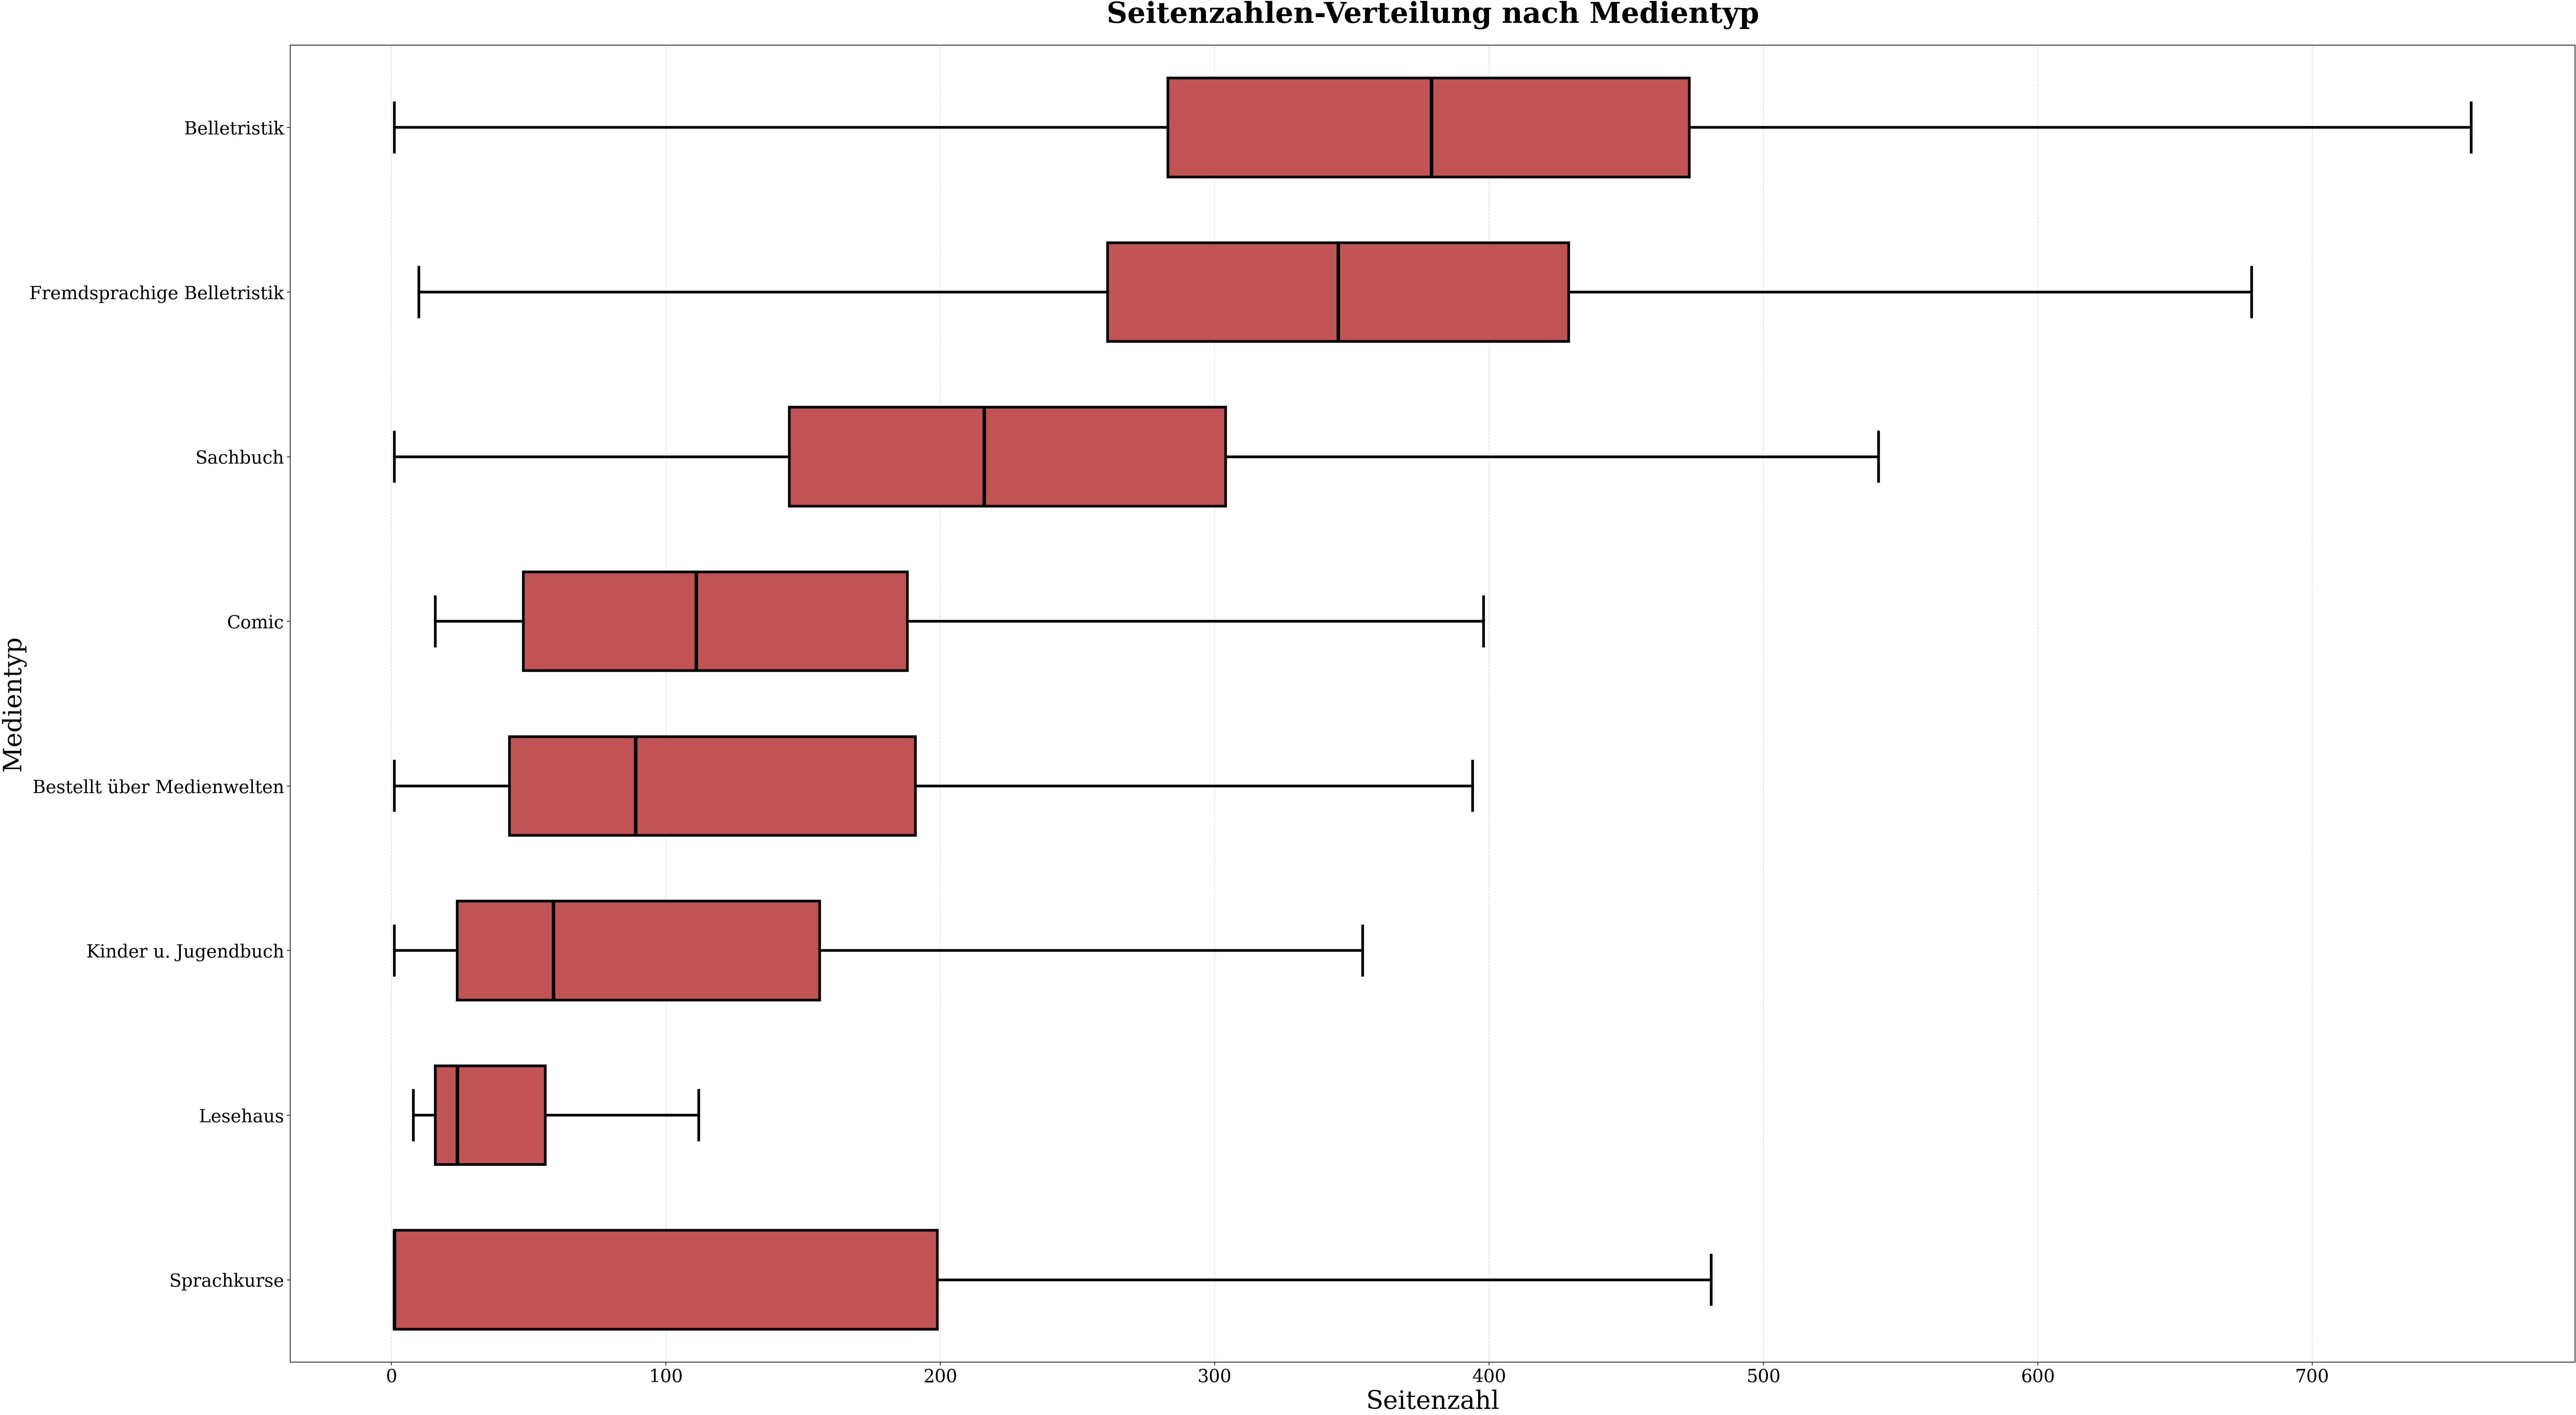

## Tabelle der Medientypen und deren Seitenzahlen-Statistiken

,Medientyp,count,mean,median,std,min,max
0,Belletristik,231807,392.3300,379.0000,173.3700,1,6084
1,Bestellt über Medienwelten,536,138.7400,89.0000,142.3500,1,1463
2,Comic,121183,135.2000,111.0000,106.3000,16,1792
3,Fremdsprachige Belletristik,23842,361.7400,345.0000,155.6500,10,1635
4,Kinder u. Jugendbuch,639605,111.5900,59.0000,128.0000,1,3564
5,Lesehaus,607,44.5700,24.0000,44.7100,8,256
6,Sachbuch,320819,251.1400,216.0000,158.4800,1,3810
7,Sprachkurse,6498,89.9900,1.0000,118.8500,1,798


In [5]:
order = (
    df_clean
    .groupby("Medientyp")["_pages_num"]
    .median()
    .sort_values()
    .index
)

data = [df_clean[df_clean["Medientyp"] == m]["_pages_num"] for m in order]

fig, ax = plt.subplots(figsize=(40, 22), dpi=100)

bp = ax.boxplot(
    data,
    vert=False,
    labels=order,
    showfliers=False,
    patch_artist=True,
    widths=0.6,
    boxprops=dict(linewidth=3),
    whiskerprops=dict(linewidth=3),
    capprops=dict(linewidth=3),
    medianprops=dict(linewidth=4, color="black")
)

for box in bp["boxes"]:
    box.set_facecolor("#C05353")

ax.grid(axis="x", linestyle="--", alpha=0.4)

for median in bp["medians"]:
    median.set_linewidth(4)

# Fonts
ax.tick_params(axis='both', labelsize=20)
ax.set_title(
    "Seitenzahlen-Verteilung nach Medientyp",
    fontsize=32,
    fontweight="bold",
    pad=25
)
ax.set_xlabel("Seitenzahl", fontsize=28)
ax.set_ylabel("Medientyp", fontsize=28)

plt.subplots_adjust(left=0.28, right=0.97, top=0.9, bottom=0.08)
plt.show()

# Table of statistics per media type
stats = (
    df_clean
    .groupby("Medientyp")["_pages_num"]
    .agg(["count", "mean", "median", "std", "min", "max"])
    .round(2)
    .reset_index()
)
# Format the columns as integers where appropriate to avoid comma formatting
stats['count'] = stats['count'].astype(int)
stats['min'] = stats['min'].astype(int)
stats['max'] = stats['max'].astype(int)

display(Markdown("## Tabelle der Medientypen und deren Seitenzahlen-Statistiken"))
display(stats)

## Analyze page count for Langeuage courses

In [6]:
sprachkurse_data = df_clean[df_clean['Medientyp'] == 'Sprachkurse']['_pages_num']

print("=== Sprachkurse Pages Distribution ===")
print(f"Total count: {len(sprachkurse_data)}")
print(f"\nValue counts (top 15):")
print(sprachkurse_data.value_counts().head(15))
print(f"\nPercentiles:")
print(sprachkurse_data.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
print(f"\nRows with 1 page: {(sprachkurse_data == 1).sum()} ({(sprachkurse_data == 1).sum() / len(sprachkurse_data) * 100:.1f}%)")
print(f"Rows > 100 pages: {(sprachkurse_data > 100).sum()} ({(sprachkurse_data > 100).sum() / len(sprachkurse_data) * 100:.1f}%)")

=== Sprachkurse Pages Distribution ===
Total count: 6498

Value counts (top 15):
_pages_num
1.0000      3282
256.0000     175
240.0000     154
2.0000       128
208.0000     113
128.0000     103
176.0000      86
3.0000        84
4.0000        82
174.0000      64
224.0000      59
304.0000      58
200.0000      54
250.0000      53
352.0000      50
Name: count, dtype: int64

Percentiles:
0.2500     1.0000
0.5000     1.0000
0.7500   199.0000
0.9000   256.0000
0.9500   304.0000
0.9900   368.0000
Name: _pages_num, dtype: float64

Rows with 1 page: 3282 (50.5%)
Rows > 100 pages: 2381 (36.6%)


So language courses have a median of 1 page because many of them could be audio or video courses with only a booklet or single page as accompanying material. So the median is low, but there are some language courses with a lot of pages (textbooks), which raises the mean.
Because of this, we might consider excluding "Sprachkurse" from certain analyses or visualizations to avoid skewing the results.

## Data Cleanup 2.0

In [7]:
## Removing Sprachkurse for further analysis
df_clean = df_clean[df_clean['Medientyp'] != 'Sprachkurse']
print(f"Anzahl der Datensätze nach Entfernen von Sprachkursen: {len(df_clean)}")

Anzahl der Datensätze nach Entfernen von Sprachkursen: 1338399


# Visualize the relationship between number of pages and late returns.

In [8]:

df_clean['is_late'] = df_clean['Tage_zu_spät'] > 0
# Group by page count bins and calculate the proportion of late returns
# Define bins for page counts (e.g., 0-100, 100-200, etc.)
bins = [0, 100, 200, 300, 400, 500, 600, 800, 1000, df_clean['_pages_num'].max()]
labels = ['0-100', '100-200', '200-300', '300-400', '400-500', '500-600', '600-800', '800-1000', '1000+']
df_clean['page_bins'] = pd.cut(df_clean['_pages_num'], bins=bins, labels=labels)

# Calculate late return statistics per page bin
stats = df_clean.groupby('page_bins', observed=True).agg(
    total_count=('is_late', 'count'),
    late_count=('is_late', 'sum'),
    late_percentage=('is_late', 'mean')
).reset_index()

print(stats)

  page_bins  total_count  late_count  late_percentage
0     0-100       482101       21558           0.0447
1   100-200       309884       14844           0.0479
2   200-300       211452        9790           0.0463
3   300-400       161743        6727           0.0416
4   400-500        91432        3483           0.0381
5   500-600        44881        1761           0.0392
6   600-800        25449        1182           0.0464
7  800-1000         7245         398           0.0549
8     1000+         4212         241           0.0572


## Number of late returns by page count bins

/tmp/ipykernel_44946/588571879.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


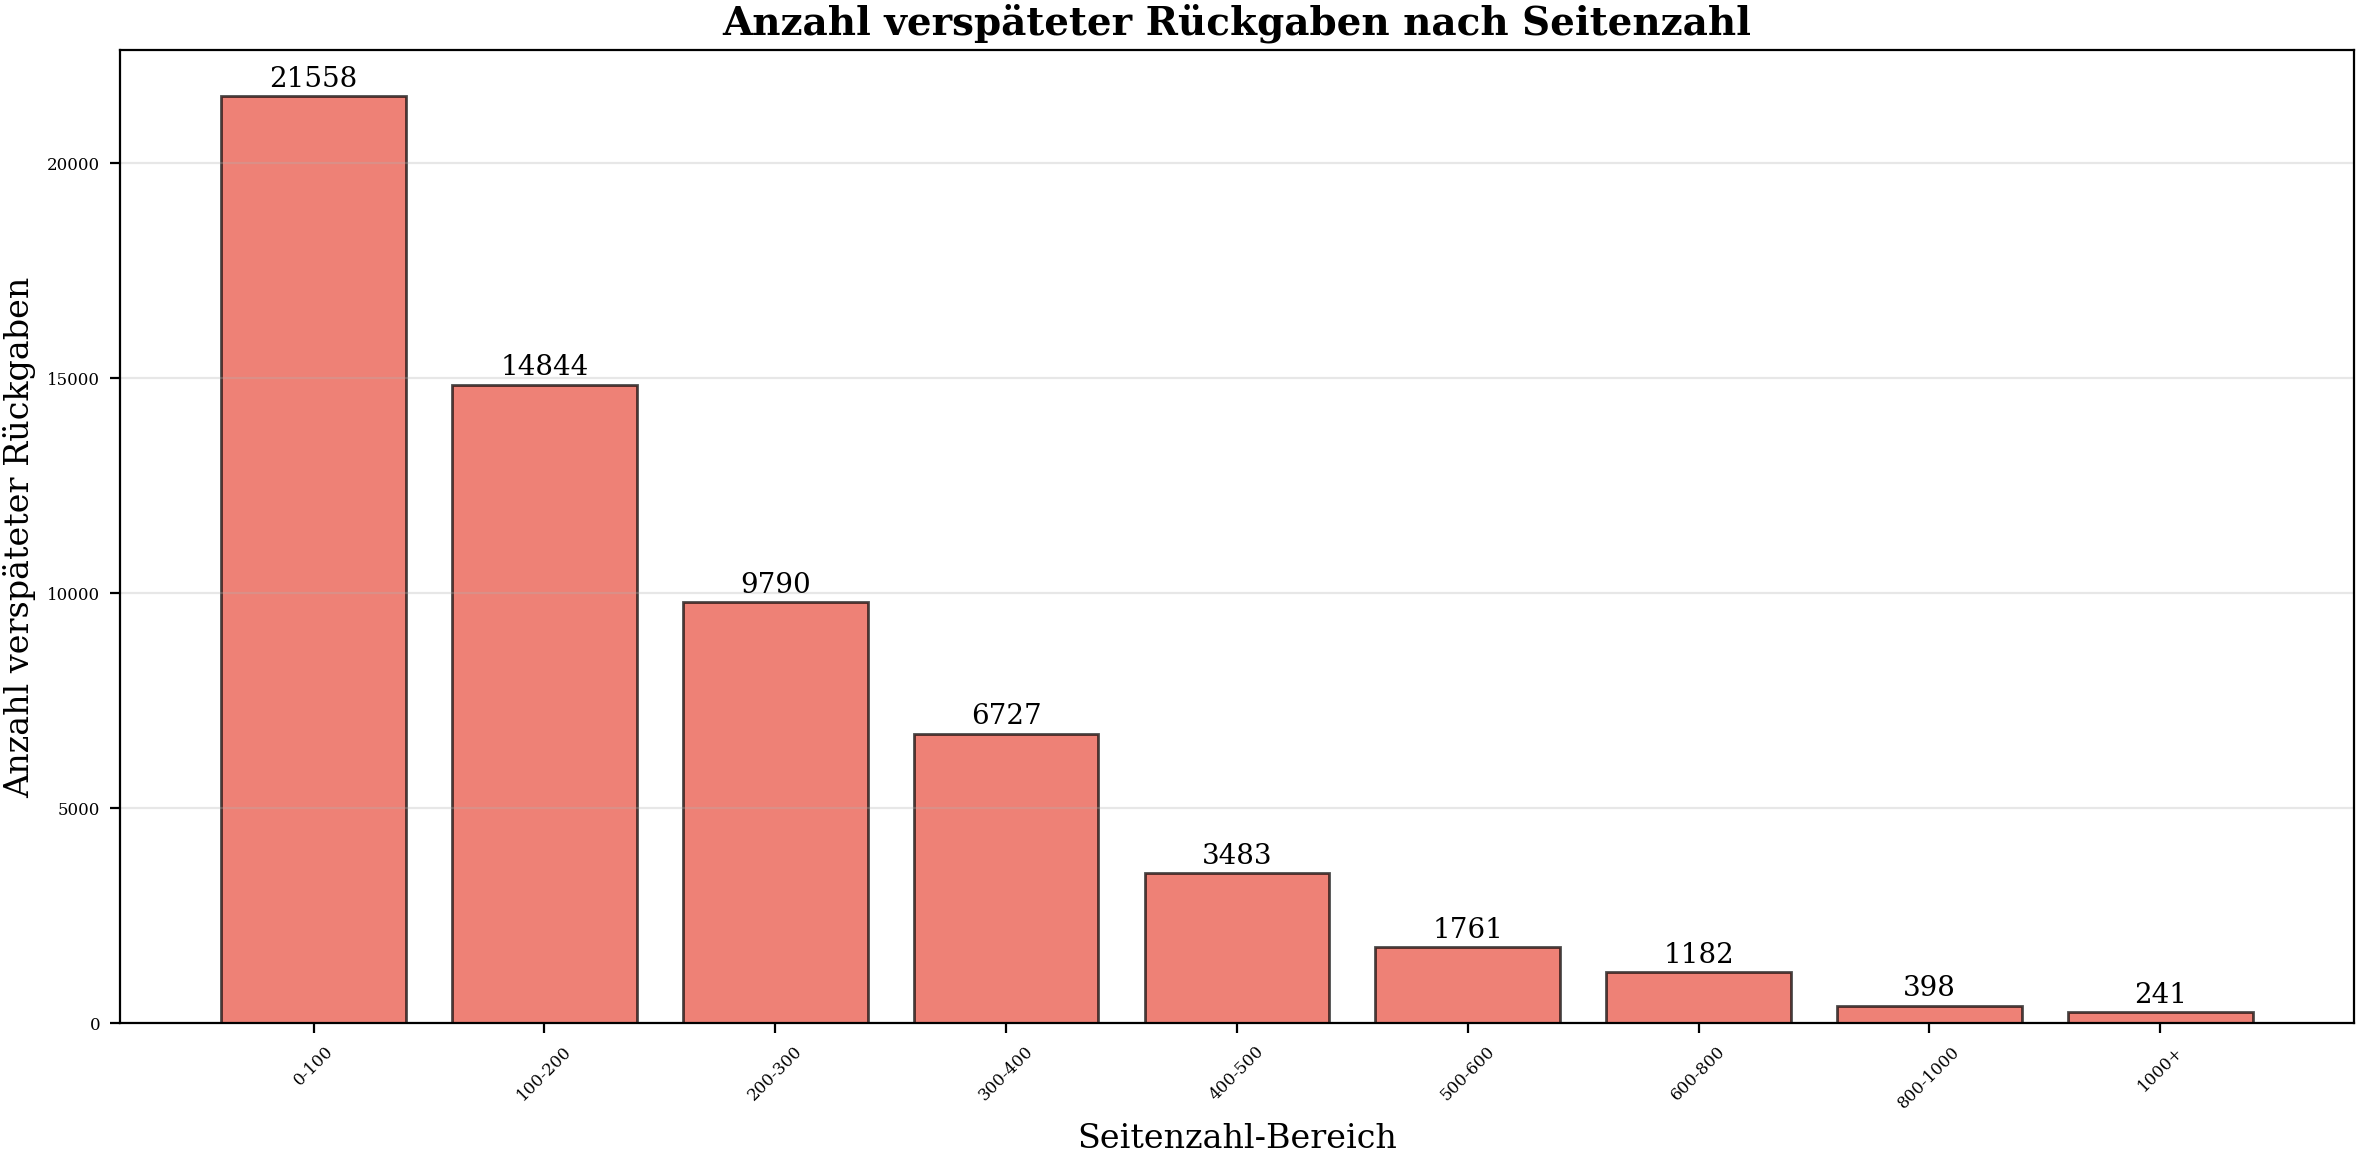

In [9]:
# plot late returns by page bins
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(stats['page_bins'].astype(str), stats['late_count'], color='#e74c3c', alpha=0.7, edgecolor='black')
ax.set_xlabel('Seitenzahl-Bereich', fontsize=12)
ax.set_ylabel('Anzahl verspäteter Rückgaben', fontsize=12)
ax.set_title('Anzahl verspäteter Rückgaben nach Seitenzahl', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.tick_params(axis='x', rotation=45)

# Annotate bars with counts
for i, v in enumerate(stats['late_count']):
    ax.text(i, v + 100, str(int(v)), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Percentage of late returns by page count bins

/tmp/ipykernel_44946/4227521666.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


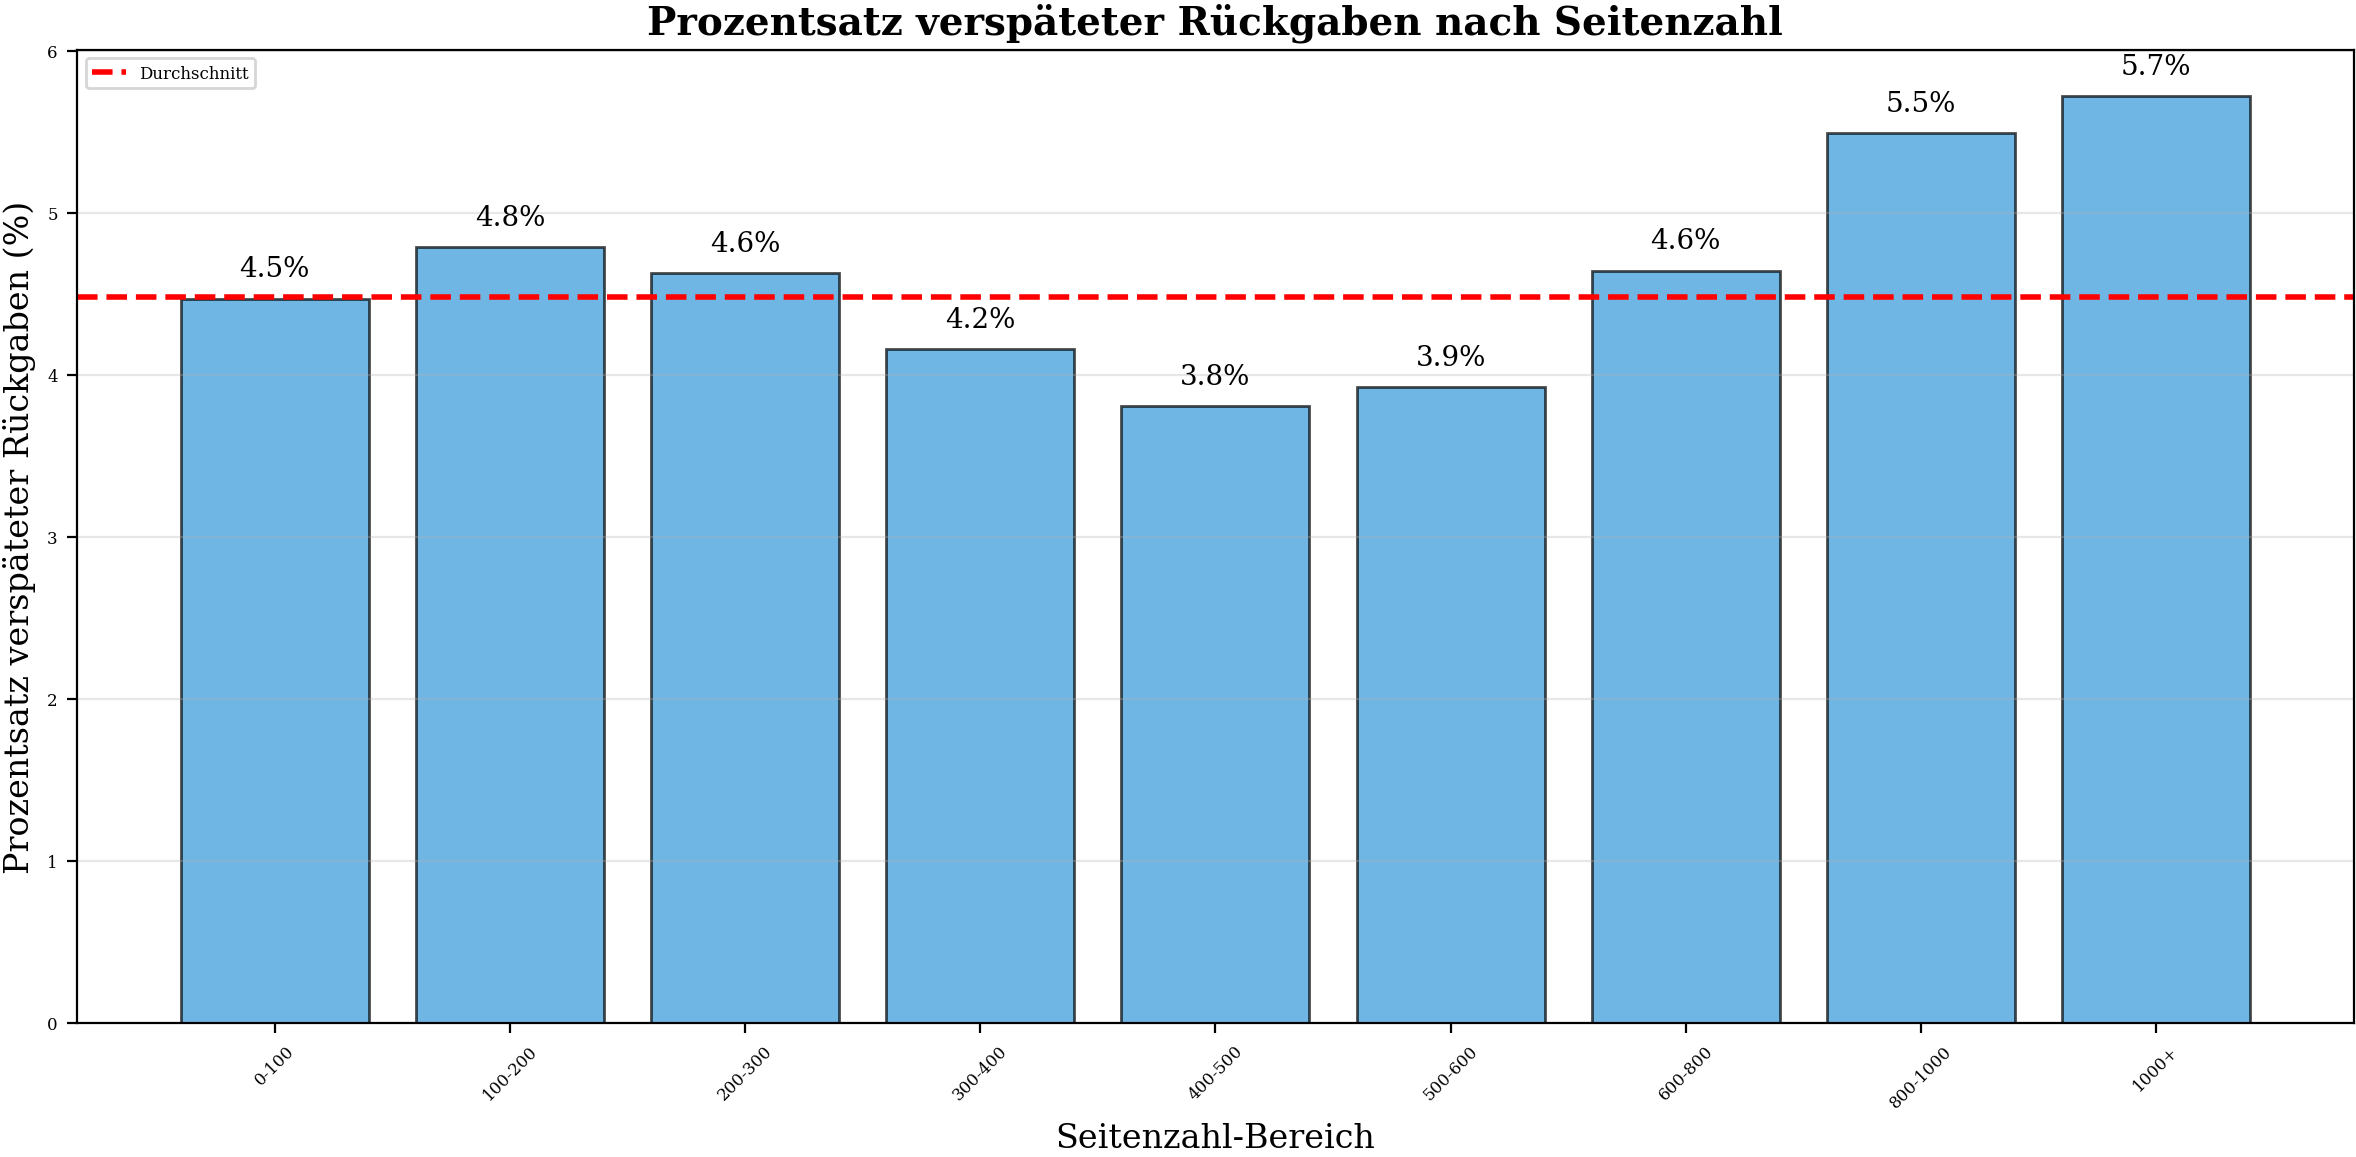


Gesamtanteil verspäteter Rückgaben: 4.48%


In [10]:
# Plot percentage of late returns by page bins
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(stats['page_bins'].astype(str), stats['late_percentage'] * 100, color='#3498db', alpha=0.7, edgecolor='black')
ax.set_xlabel('Seitenzahl-Bereich', fontsize=12)
ax.set_ylabel('Prozentsatz verspäteter Rückgaben (%)', fontsize=12)
ax.set_title('Prozentsatz verspäteter Rückgaben nach Seitenzahl', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.tick_params(axis='x', rotation=45)
ax.axhline(y=(df_clean['is_late'].mean() * 100), color='red', linestyle='--', linewidth=2, label='Durchschnitt')
ax.legend()

# Annotate bars with percentage values
for i, v in enumerate(stats['late_percentage'] * 100):
    ax.text(i, v + 0.1, f'{v:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nGesamtanteil verspäteter Rückgaben: {df_clean['is_late'].mean() * 100:.2f}%")

## Insights: Page Count and Late Returns

The analysis shows an interesting connection between the number of pages and late book returns:

### Key Findings:

1. **Thin books (0-100 pages)**: Have the highest absolute number of late returns (~21,500), but the percentage (4.5%) is only slightly above average (4.48%).

2. **Thick books (800+ pages)**: Show a notably higher rate of late returns (5.5-5.7%), even though the absolute number is low (~240-400 cases).

3. **Medium size (300-600 pages)**: Have the lowest late return rates (3.8-4.2%), which suggests that users are more reliable with books of this size.

### Interpretation:

- **Very thick books**: Users might underestimate them and need more time to read
- **Very thin books**: Borrowed frequently (high absolute numbers), but not necessarily more often late relative to total borrowings
- **Sweet spot**: Books with 300-600 pages are returned most reliably

This could be considered when setting loan periods for different book types.